# Generative Basic Assignment (2024/03/13)
#### Questions(1,2) are below
#### Contact -> toa2413@naver.com / 송인혁(투빅스20기)

In [4]:
import datetime
import os

import torch

import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



### Q1. Encoder/Decoder Implementation
    Show me your visualizations(MNIST images) using a VAE model made up of your own 'Encoder2/Decoder2'
    I can see your visualizations at the last part of this code file (Assignment 1 ; Visualization)
    
***You can refer to the examples right under this markdown, please make your own Encoder (Class name; Encoder2/Decoder2)***

In [69]:
# You can freely choose one of architectures you want that looks promising
class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim2)
        self.mean = nn.Linear(hidden_dim2, latent_dim)
        self.var = nn.Linear (hidden_dim2, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                         
        return mean, log_var

In [70]:
class Encoder2(nn.Module):
    def __init__(self,x_dim,h_dim,z_dim):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(x_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(h_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.mu = nn.Linear(h_dim,z_dim)
        self.var = nn.Linear(h_dim,z_dim)

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)

        mu = self.mu(x)
        logvar = self.var(x)

        return mu, logvar

In [71]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim2)
        self.hidden2 = nn.Linear(hidden_dim2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [72]:
class Decoder2(nn.Module):
    def __init__(self,x_dim,h_dim,z_dim):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(z_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(h_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.p = nn.Sequential(
                nn.Linear(h_dim,x_dim),
                nn.Sigmoid()
            )


    def forward(self,z):
        z = self.fc1(z)
        z = self.fc2(z)

        p = self.p(z)

        return p

In [73]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder.to(device)
        self.Decoder = Decoder.to(device)

    # Think about why you need reparameterization trick (Hint; backpropagation)
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon                          
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var

In [74]:
# Any modifications are allowed depending on your own Encoder2/Decoder2
# -----------------------------------
beta = 1
x_dim  = 784
hidden_dim = 512
latent_dim = 256
epochs = 50
batch_size = 100
# -----------------------------------



# encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
encoder = Encoder2(x_dim,hidden_dim,latent_dim)

# decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, output_dim = x_dim)
decoder = Decoder2(x_dim,hidden_dim,latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Q2. (Optional Assignment)
    Refering to Beta-VAE(https://openreview.net/forum?id=Sy2fzU9gl), give any kind of manipulations on pre-made loss function, and visualize your samples.
    It would be nice to see whether the fidelity of sample data is improved or not! Also guess why.
***Warning)  you don't have to take all the contents of this paper! Look carefully at the Equation (4)***

In [75]:
# (Optional Assignment)
def loss_function(x, x_hat, mean, log_var,beta):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Think about how to calculate KLDivergence in closed form (Hint; assumptions for Gaussian), please refer to the following links
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    KLD = beta * KLD
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [76]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var,beta)
        loss = BCE + KLD
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [77]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var,beta)
            loss = BCE + KLD

            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())

In [78]:
# Trackning the process
# If you have difficulty on installing 'tqdm', modifications are allowed. Not necessary 
from tqdm.auto import tqdm

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 545.821992
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 200.008926
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 189.104453
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 187.360547
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 182.301270
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 165.216055
======> Epoch: 0 Average loss: 187.6618


Train Epoch: 1 [0/60000 (0%)]	 Loss: 165.878047
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 158.511484
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 156.434043
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 150.429170
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 148.489121
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 140.618105
======> Epoch: 1 Average loss: 153.5375


Train Epoch: 2 [0/60000 (0%)]	 Loss: 142.807402
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 143.315430
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 143.412178
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 137.310635
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 138.761602
Train Epoch: 2 [50000/60000 (8

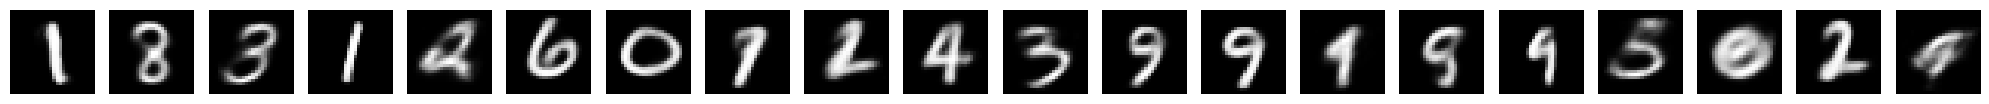

In [79]:
# After training decoder, begin visualize what comes after decoder given input z
def visualize(decoder,z):
    x_sample = decoder(z.to(device)).view(20,28,28).detach().cpu().numpy()
    fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sample[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

z_sample = torch.randn(20,256)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)


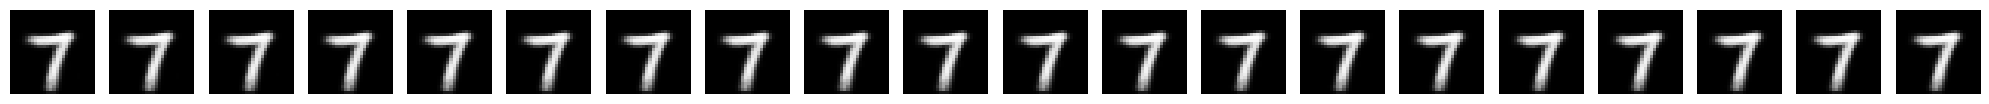

In [80]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(256)
# Make copies
z = z.repeat(20,1)

# Interpolation in latent space z 
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)

## Answer(Q2; Optional) : Please write any codes or statements below this space


In [84]:
beta = 3

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)



# encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
encoder = Encoder2(x_dim,hidden_dim,latent_dim)

# decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, output_dim = x_dim)
decoder = Decoder2(x_dim,hidden_dim,latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 546.905938
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 206.876777
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 196.302031
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 203.547852
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 199.799883
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 192.504004
======> Epoch: 0 Average loss: 201.5448


Train Epoch: 1 [0/60000 (0%)]	 Loss: 191.039688
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 181.613867
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 186.216445
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 180.748516
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 181.916211
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 175.959023
======> Epoch: 1 Average loss: 182.7485


Train Epoch: 2 [0/60000 (0%)]	 Loss: 178.024258
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 173.610625
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 177.475371
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 169.301641
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 172.820371
Train Epoch: 2 [50000/60000 (8

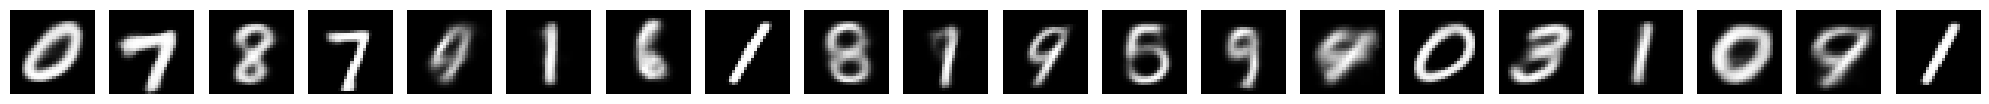

In [85]:
z_sample = torch.randn(20,256)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)

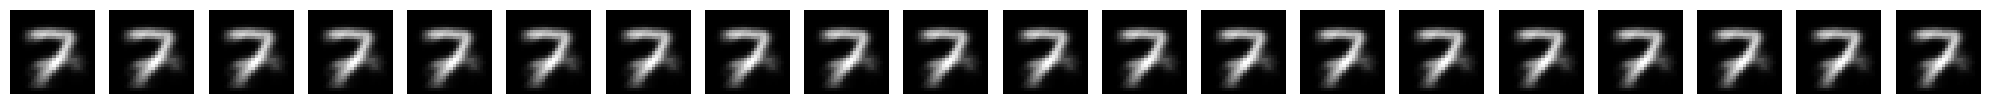

In [86]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(256)
# Make copies
z = z.repeat(20,1)

# Interpolation in latent space z 
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)